<a href="https://colab.research.google.com/github/HibaDoudar/Machine-Learning-Projects/blob/main/ML_83_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook classfies Patenet text description into 8 categories A to G. 

We will use Text Classification dataset that contains 7210 text from the US Patent website. The dataset is imbalanced, meaning they contain unequal number of categories. These are split into 2163 texts for testing and 5047 texts for training. 

This notebook uses keras and sklearn libraries to build and train models. 

# Setup


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.ensemble import GradientBoostingClassifier
from tokenize import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
import pandas, xgboost, numpy,  string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, classification_report

## Download the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv('/content/drive/MyDrive/Jobs/MachineLearningEngineerUofT/Text Classification/final_dataset.csv')

Mounted at /content/drive


## Explore the data

let's take a moment to understand the format of the data. Each example contains information as certification number, file, dates, and information on the aparatus description. The sentences are not preprocessed in anyway. The IPC - label is an alphabetic category between A and G representing class of the Patent. 

In [ ]:
df.head()

,content,IPC
0,"﻿ US 9,423,954 C1 (11,805th) Graphical user in...",G
1,"﻿ US 10,925,202 B2 Paddle scraper for rolling ...",A
2,"﻿ US 10,925,203 B2 Air seeder downforce contro...",A
3,"﻿ US 10,925,204 B2 Hydraulic control system of...",A
4,"﻿ US 10,925,205 B2 Tractor-trailer combination...",A


Let's look at the dataset imbalance:

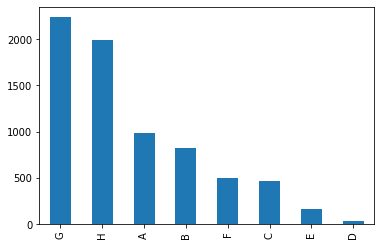

In [ ]:
df['IPC'].value_counts().plot(kind='bar')

Let's look at word cloud for each category:

<Figure size 432x288 with 0 Axes>

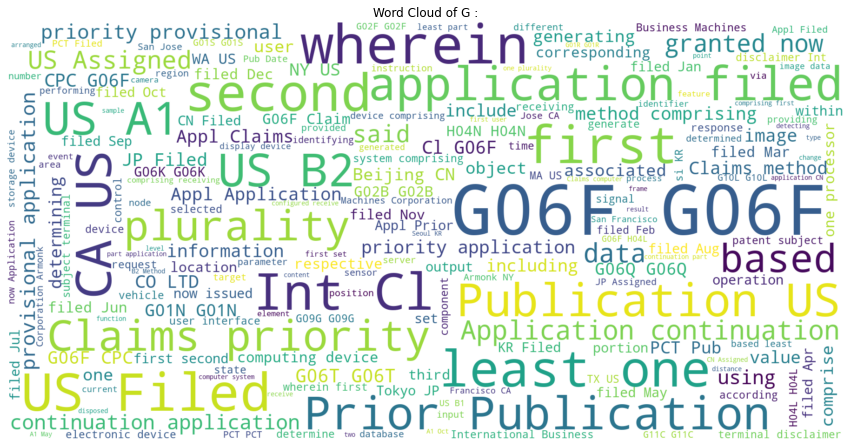

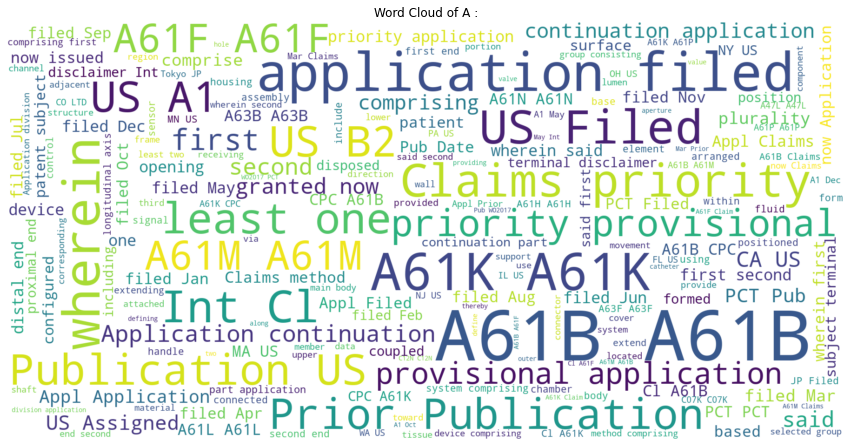

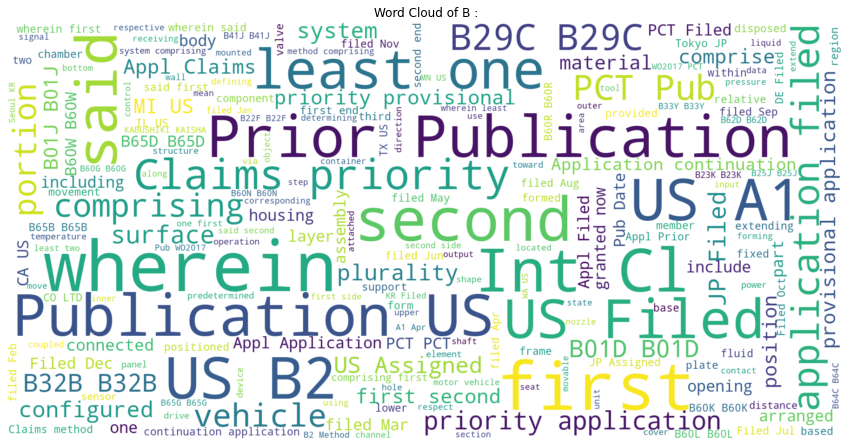

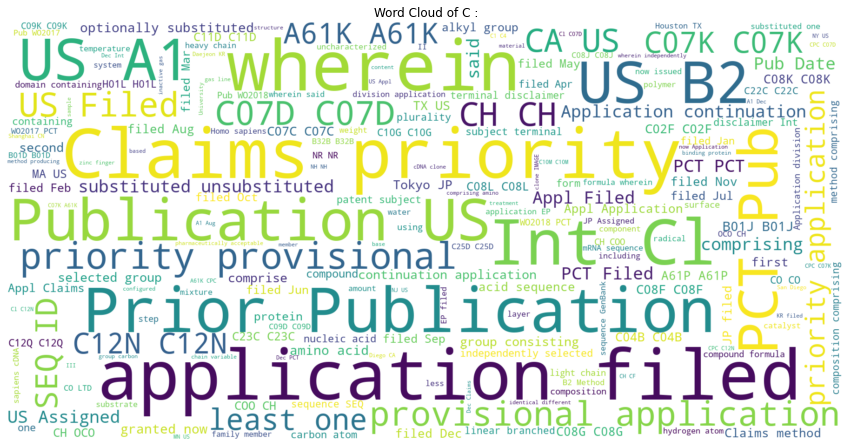

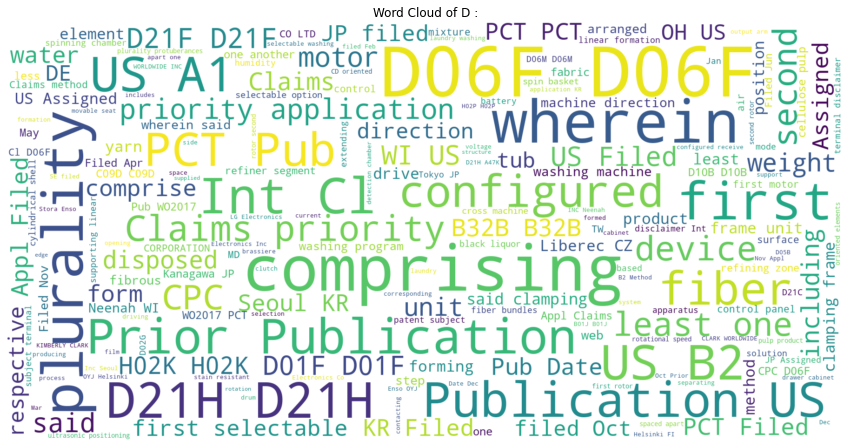

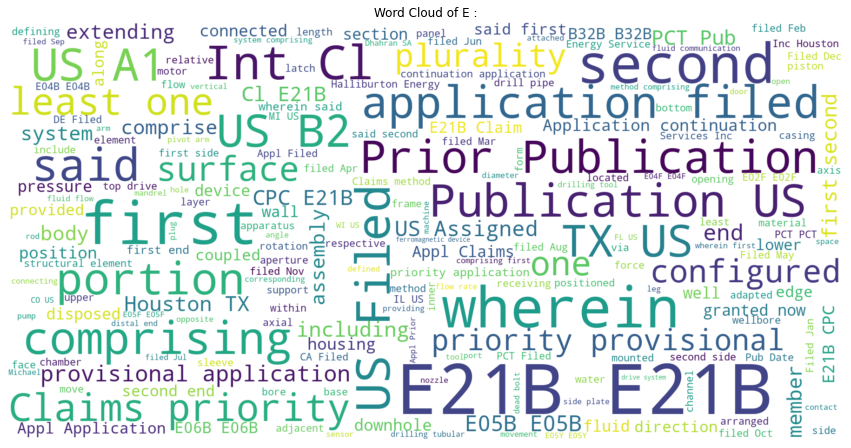

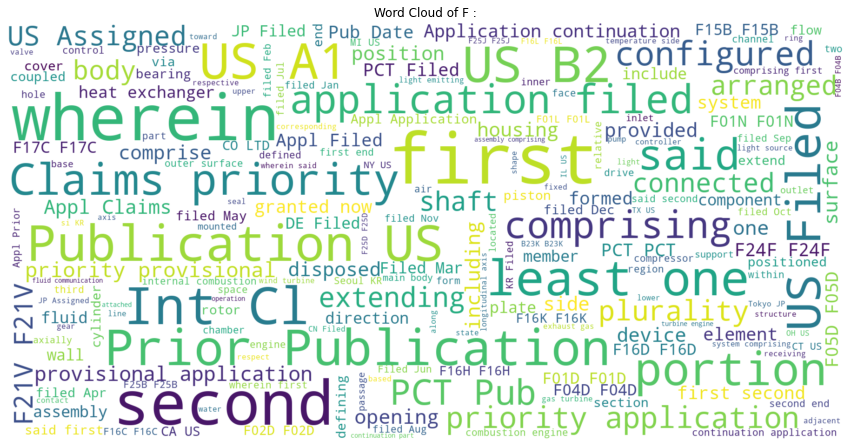

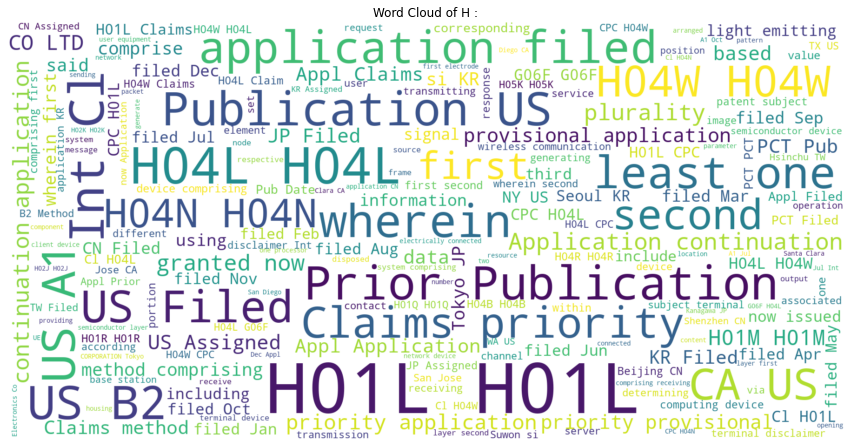

In [ ]:
# iterate through the csv file
from wordcloud import WordCloud
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for val in df.IPC.unique():
  text = df.loc[df['IPC'] == val] 

  all_words = ''.join([text for text in text['content']])
  wordcloudp = WordCloud(width=1800, height=900, background_color="white", max_font_size=150).generate(all_words)

  plt.figure(figsize=(15, 10))
  plt.title("Word Cloud of {} :".format(val))
  plt.imshow(wordcloudp, interpolation="bilinear")
  plt.axis('off')
  plt.show()



## Split and processing the data

Split the dataset into train and validation sets. The validation set is used during the model fitting to evaluate any metrics. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [ ]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(df['content'], df['IPC'], test_size=0.3)

In [ ]:
# label encode the target variable
#Encode target labels with value between 0 and n_classes-1 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

## Feature Engineering
The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.

2.1 Count Vectors as features
2.2 TF-IDF Vectors as features

Word level
N-Gram level
Character level
2.3 Word Embeddings as features
2.4 Text / NLP based features
2.5 Topic Models as features



In [ ]:

# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
train_x = train_x.to_numpy()

#fit only train data and transform using fitted countvectorizer on test data

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.fit_transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [ ]:
#load the pre-trained word-embedding vectors 
embeddings_index = df['content']

# create a tokenizer 
token = text.Tokenizer()

# changing to train_x fit
token.fit_on_texts(train_x)
word_index = token.word_index

# create token-embedding mapping 

embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 2.2 TF-IDF Vectors as features
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

# do it like this

xtrain_tfidf =  tfidf_vect.fit_transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

xtrain_tfidf_ngram =  tfidf_vect_ngram.fit_transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.fit_transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

## 3. Model Building
The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement following different classifiers for this purpose:

Naive Bayes Classifier

Support Vector Machine

Bagging Models


In [ ]:
# import libraries 
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [ ]:
def run_kfold(classifier, feature_vector_train, label):
    
    X= feature_vector_train
    Y= label
    
    kf=KFold(n_splits=9, random_state=None, shuffle=False)#n splits previously n_folds
    outcomes =[]
    fold =0

    
    for train_index, test_index in kf.split(X):
      fold +=1
      X_train, X_test = X[train_index], X[test_index]
      Y_train, Y_test = Y[train_index], Y[test_index]

      # fit the training dataset on the classifier
      model = classifier.fit(X_train, Y_train)
      # predict the labels on test and train dataset
      predictions = model.predict(X_test)

    
      f1score= f1_score(Y_test, predictions,average = 'weighted' )
      #print(f1score)

      Recall= recall_score(Y_test, predictions,average = 'weighted')
      #print(Recall)
    
      Precision = precision_score(Y_test, predictions,average = 'weighted')
      #print(Precision1)

      outcomes.append((f1score, Recall, Precision))


    df = pd.DataFrame(outcomes, columns=['F1_score', 'Recall','Precision'], index=range(1,10))
    print("9 Folds cross validation results:")
    print(df)

    print("#####################################################" )
 
    print('The average F1_score:', df['F1_score'].mean())
    print('The variance F1_score:', df['F1_score'].var())

    print("#####################################################" )
    print('The average Recall:', df['Recall'].mean())
    print('The variance Recall:', df['Recall'].var())

    print("#####################################################" )
    print('The average Precision:', df['Precision'].mean())
    print('The variance Precision:', df['Precision'].var())
    
    #print ('F1 score:', f1_score(valid_y, predictions, average = 'weighted'))
    #print ('Recall:', recall_score(valid_y, predictions, average='weighted'))
    #print ('Precision:', precision_score(valid_y, predictions, average='weighted'))
    print ('\n clasification report:\n', classification_report(Y_test,predictions))
    print ('\n confussion matrix:\n',confusion_matrix(Y_test, predictions))

In [ ]:
# Naive Bayes on Count Vectors
nb = run_kfold(naive_bayes.MultinomialNB(), xtrain_count, train_y)

9 Folds cross validation results:
   F1_score    Recall  Precision
1  0.731826  0.737968   0.757259
2  0.733515  0.737968   0.752069
3  0.714795  0.720143   0.751177
4  0.743234  0.752228   0.737597
5  0.746366  0.748663   0.754302
6  0.732657  0.739750   0.734807
7  0.721273  0.726786   0.741482
8  0.754598  0.762500   0.781599
9  0.750069  0.760714   0.767625
#####################################################
The average F1_score: 0.7364815482488148
The variance F1_score: 0.00017535685848107902
#####################################################
The average Recall: 0.7429689047336107
The variance Recall: 0.00020722925028372145
#####################################################
The average Precision: 0.753101844882145
The variance Precision: 0.0002195783690073627

 clasification report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        75
           1       0.63      0.71      0.67        59
           2       0.76      

## Naive Bayes
Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature

In [ ]:
print(color.BOLD +"Naive Bayes on Count Vectors" +color.END)
nb1 = run_kfold(naive_bayes.MultinomialNB(), xtrain_count, train_y )

print(color.BOLD + "Naive Bayes on Word Level TF IDF Vectors" +color.END)
nb2 = run_kfold(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y)


print(color.BOLD +"Naive Bayes on Ngram Level TF IDF Vectors" +color.END)
nb3 = run_kfold(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y )


print(color.BOLD +"Naive Bayes on Character Level TF IDF Vectors" +color.END)
nb4 = run_kfold(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y )


Naive Bayes on Count Vectors
9 Folds cross validation results:
   F1_score    Recall  Precision
1  0.731826  0.737968   0.757259
2  0.733515  0.737968   0.752069
3  0.714795  0.720143   0.751177
4  0.743234  0.752228   0.737597
5  0.746366  0.748663   0.754302
6  0.732657  0.739750   0.734807
7  0.721273  0.726786   0.741482
8  0.754598  0.762500   0.781599
9  0.750069  0.760714   0.767625
#####################################################
The average F1_score: 0.7364815482488148
The variance F1_score: 0.00017535685848107902
#####################################################
The average Recall: 0.7429689047336107
The variance Recall: 0.00020722925028372145
#####################################################
The average Precision: 0.753101844882145
The variance Precision: 0.0002195783690073627

 clasification report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        75
           1       0.63      0.71      0.67        59


## Implementing a SVM Model
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes.

In [ ]:
# takes time to run
# SVM on Ngram Level TF IDF Vectors
print ("SVM, N-Gram Vectors: ")
#Create a svm Classifier
clf_svm = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto') 
svm1 = run_kfold(clf_svm, xtrain_tfidf_ngram, train_y)


SVM, N-Gram Vectors: 
9 Folds cross validation results:
   F1_score    Recall  Precision
1  0.857136  0.862745   0.856481
2  0.859066  0.860963   0.858511
3  0.864519  0.868093   0.872761
4  0.863114  0.868093   0.863321
5  0.874166  0.877005   0.880793
6  0.875833  0.880570   0.884525
7  0.876567  0.876786   0.880709
8  0.842806  0.846429   0.845767
9  0.830186  0.833929   0.831974
#####################################################
The average F1_score: 0.8603771420372657
The variance F1_score: 0.0002435321759672724
#####################################################
The average Recall: 0.8638457403163285
The variance Recall: 0.00023304060315631288
#####################################################
The average Precision: 0.863871508224046
The variance Precision: 0.00031303396494911117

 clasification report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83        75
           1       0.76      0.75      0.75        59
       

## Boosting Model
Implementing Xtereme Gradient Boosting Model

Boosting models are another type of ensemble models part of tree based models. Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing).

In [ ]:
#Extereme Gradient Boosting on Count Vectors
print("Extereme Gradient Boosting on Count Vectors")
clf_xgb= xgboost.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb = run_kfold(clf_xgb, xtrain_count, train_y)


Extereme Gradient Boosting on Count Vectors
9 Folds cross validation results:
   F1_score    Recall  Precision
1  0.938630  0.944742   0.936605
2  0.958217  0.960784   0.956037
3  0.938255  0.941176   0.939562
4  0.929444  0.934046   0.928878
5  0.949279  0.951872   0.948929
6  0.947318  0.950089   0.946362
7  0.932739  0.935714   0.932032
8  0.947416  0.950000   0.948114
9  0.932099  0.935714   0.933637
#####################################################
The average F1_score: 0.9414887738524327
The variance F1_score: 9.225733851127196e-05
#####################################################
The average Recall: 0.9449042243159891
The variance Recall: 8.178732430331464e-05
#####################################################
The average Precision: 0.9411283339086105
The variance Precision: 8.389369282012983e-05

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        75
           1       0.95      0.98      0

In [ ]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
print("Extereme Gradient Boosting on Word Level TF IDF Vectors")
clf_xgb= xgboost.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb2 =  run_kfold(clf_xgb, xtrain_tfidf, train_y)


Extereme Gradient Boosting on Word Level TF IDF Vectors
9 Folds cross validation results:
   F1_score    Recall  Precision
1  0.947722  0.950089   0.948537
2  0.923399  0.928699   0.924096
3  0.937375  0.939394   0.938319
4  0.953638  0.955437   0.952984
5  0.937661  0.939394   0.938864
6  0.951579  0.953654   0.952840
7  0.938930  0.942857   0.936894
8  0.932742  0.937500   0.931447
9  0.946312  0.950000   0.950438
#####################################################
The average F1_score: 0.9410395986156532
The variance F1_score: 9.395052999322697e-05
#####################################################
The average Recall: 0.9441137566137565
The variance Recall: 7.713485293287234e-05
#####################################################
The average Precision: 0.9416021165953288
The variance Precision: 0.00010399823774456196

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97        76
           1       0.91    

In [ ]:
# Extereme Gradient Boosting on Character Level TF IDF Vectors
print("Extereme Gradient Boosting on Character Level TF IDF Vectors")
clf_xgb= xgboost.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb2 = run_kfold(clf_xgb, xtrain_tfidf_ngram_chars, train_y)


Extereme Gradient Boosting on Character Level TF IDF Vectors
9 Folds cross validation results:
   F1_score    Recall  Precision
1  0.994652  0.994652   0.994663
2  0.994638  0.994652   0.994697
3  1.000000  1.000000   1.000000
4  1.000000  1.000000   1.000000
5  1.000000  1.000000   1.000000
6  0.996430  0.996435   0.996494
7  0.996260  0.996429   0.996498
8  0.992677  0.992857   0.992937
9  0.996357  0.996429   0.996478
#####################################################
The average F1_score: 0.9967795122026882
The variance F1_score: 7.202733121712166e-06
#####################################################
The average Recall: 0.9968282262399908
The variance Recall: 6.986557159099431e-06
#####################################################
The average Precision: 0.9968630213412825
The variance Precision: 6.860786013883894e-06

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00